# A CNN-LSTM framework for the solar wind density forecasting
In this notebook we pre-process solar wind and solar binary mask for the time series analysis


## Notebook Contributors
* Andrea Giuseppe Di Francesco -- email: difrancesco.1836928@studenti.uniroma1.it
* Massimo Coppotelli -- email: coppotelli.1705325@studenti.uniroma1.it

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install torch
# !pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms


/home/peppe/miniconda3/envs/my_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def open_dataframe(total_path):
    # This function open the raw dataframe, by skipping the comments on the top of it.
    with open(total_path, 'r') as f:
        skippies = 0
        for line in f.readlines():
            # print(line)
            if line.startswith("#"):
                skippies += 1
            else:
                break

    return skippies  

path_elc = './wind_dataset/wind-2012/WI_ELM2_3DP_45129.csv'
path_ptr = './wind_dataset/wind-2012/OMNI_HRO_5MIN_45129.csv'
data_elc = pd.read_csv(path_elc, skiprows= open_dataframe(path_elc))

# data_elc = 
data_ptr = pd.read_csv(path_ptr, skiprows= open_dataframe(path_ptr))


/tmp/ipykernel_3967/56647363.py:16: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_elc = pd.read_csv(path_elc, skiprows= open_dataframe(path_elc))
/tmp/ipykernel_3967/56647363.py:19: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ptr = pd.read_csv(path_ptr, skiprows= open_dataframe(path_ptr))


### Image transformation
* In this cell is applied the image transformation for the solar binart masks.


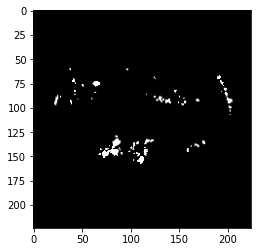

In [8]:
from PIL import Image

img = Image.open("2012_1_2_T_0_0_0.jpg_AR.jpg_BIN.jpg")

transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(), transforms.Resize((224,224))])

img = transform(img)

plt.imshow(img.permute(1, 2, 0), cmap = 'gray') 



## Solar wind density (Protons + Electron densities)

* In this cell are retrieved the values for the electrons and protons 's densities.

In [9]:

timesteps_of_interest = data_ptr['EPOCH_BIN_yyyy-mm-ddThh:mm:ss.sssZ'][data_ptr['EPOCH_BIN_yyyy-mm-ddThh:mm:ss.sssZ'].str.slice(start = 11, stop = 19) == '00:03:00']

timesteps_of_interest = timesteps_of_interest.str.slice(start = 0, stop = -5)

proton_density = data_ptr[(data_ptr['EPOCH_BIN_yyyy-mm-ddThh:mm:ss.sssZ'].str.slice(start = 11, stop = 19) == '00:03:00')]['PROTON_DENSITY_n/cc']    #[]

electron_density = data_elc[(data_elc['EPOCH_yyyy-mm-ddThh:mm:ss.sssZ'].str.slice(start = 11, stop = 19) == '00:03:00')]['ELECTRON_NO_DENSITY_#/cm3']

series_of_interest = [timesteps_of_interest, proton_density, electron_density]

columns = ['timestep (1d)', 'Proton density', 'Electron_density']

wind_dataset = pd.concat(series_of_interest, axis = 1)
wind_dataset.columns = columns

wind_dataset = wind_dataset[6:]

wind_dataset.index = list(range(0,len(wind_dataset)))


In [10]:
prediction_time = '2012-01-01T00:03:00'

H = 4  # day
D = 2  # day

resolution = pd.Timedelta(1, 'd')

def get_first_useful_date(H, D, resolution):
    ''' This function helps to understand where to start considering the solar wind dataset '''

    start_date = '2012-01-01T00:00:00'
    start_date = pd.to_datetime(start_date, format = '%Y-%m-%dT%H:%M:%S')
    delay = pd.Timedelta(D, 'd') + pd.Timedelta(3, 'm') # 3 minutes of difference, due to the different datasets' samplings.
    history = pd.Timedelta(H, 'd')

    first_useful_date = start_date + history + delay

    return first_useful_date




def get_history_images(prediction_time, H, D, resolution):
    ''' This function is needed to take a solar wind measure occurring in a prediction date, and retrieve all the data requested for the forecasting. 
        INPUTs: prediction_time: Solar wind density datetime, H: History value, D: Time between last image and the prediction time, resolution: Sampling time of the data
        OUTPUT: list of the sun images date to take. '''
    prediction_time = pd.to_datetime(prediction_time, format = '%Y-%m-%dT%H:%M:%S')
    
    delay = pd.Timedelta(D, 'd') + pd.Timedelta(3, 'm') # 3 minutes of difference, due to the different datasets' samplings.
    history = pd.Timedelta(H, 'd')
    

    right_limit = prediction_time - delay # Closest time to the prediction
    left_limit = right_limit - history

    times_of_interest = [str(left_limit)]
    current_time = left_limit

    while current_time != right_limit:

        current_time += resolution
        times_of_interest.append(str(current_time))

    
    return times_of_interest

def get_sun_format(element):

    tail = '.jpg_AR.jpg_BIN.jpg'

    year = element[0:4]
    if element[5] == str(0):
        month = element[6]
    else:
        month = element[5:7]
    if element[8] == str(0):
        day = element[9]
    else:
        day = element[8:10]

    if element[11] == str(0):
        hours = element[12]
    else:
        hours = element[11:13]
    
    if element[14] == str(0):
        minutes = element[15]
    else:
        minutes = element[14:16]
    
    if element[17] == str(0):
        seconds = element[18]
    else:
        seconds = element[17:19]
    
    new_format = year+'_'+month+'_'+day+'_'+'T'+'_'+hours+'_'+minutes+'_'+seconds+tail
    return new_format

def get_numpy_image(image):
    
    try:
        img = Image.open('./ARI_Images/'+image)

        transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(), transforms.Resize((224,224))])

        img = transform(img)

        img = np.array(img).tolist()
        return img
    except FileNotFoundError:
        print('./ARI_Images/'+image)
        pass
    


In [11]:
dataframe = wind_dataset


def get_full_dataset(wind_df, H, D, resolution):

    diz = {}

    for d_idx in range(len(dataframe)):
        prediction_date = dataframe.loc[d_idx, 'timestep (1d)']
        dates_list = get_history_images(prediction_date, H, D, resolution)
        
        for el in dates_list:
            if el in diz:
                dates_list.remove(el)

        sun_list = list(map(get_sun_format, dates_list))



        inter_diz = {dates_list[idx]: get_numpy_image(sun_list[idx]) for idx in range(len(dates_list))}

        diz.update(inter_diz)
    return diz

diz = get_full_dataset(dataframe, H, D, resolution)



./ARI_Images/2012_1_30_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_1_30_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_2_1_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_1_30_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_2_1_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_2_1_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_3_5_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_3_5_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_3_5_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_3_31_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_3_31_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_3_31_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_5_23_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_5_23_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_5_25_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_5_23_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_5_25_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_5_25_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_6_5_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Images/2012_6_5_T_0_0_0.jpg_AR.jpg_BIN.jpg
./ARI_Im

In [12]:
import json 
save_file = open('ARI_image_dataset.json',"w")
json.dump(diz, save_file)

